# Markov Chain Monte Carlo - In Class Code Along

In class, we were introduced to Markov Chain Monte Carlo, a technique that creates samples from the posterior distribution by reversing a standard Markov Chain that has its *equilibrium distribution* as its *target posterior distribution*.

If we think back to Bayes Formula - it's difficult to calculate the posterior in a closed form manner. Therefore, when we want to calculate the posterior, we can utilize a Markov Chain and it's model of the probability of states, along with the random sampling Monte Carlo Method to estimate the posterior. Typically, to sample from the posterior, we could have to solve an inverted Bayes formula - however with Markov Chain Monte Carlo, we can construct a Markov Chain whose equilibrium distribution matches our posteriors distribution and then apply the Monte Carlo Method to construct a distribution very similar to that of our posterior's. 

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

sns.set_style('white')
%matplotlib inline 

We're going to be working with the airport operations data, so let's set up our data. We're going to use ```c.replace``` to replace spaces and dashes with underscores for ease of use. 

In [5]:
air = pd.read_csv('/Users/patricksmith/Desktop/airport_operations.csv')
air.columns = [c.replace(' ', '_').replace('-',"_") for c in air.columns]
air.head(2)

,airport,year,departures_for_metric_computation,arrivals_for_metric_computation,percent_on_time_gate_departures,percent_on_time_airport_departures,percent_on_time_gate_arrivals,average_gate_departure_delay,average_taxi_out_time,average_taxi_out_delay,average_airport_departure_delay,average_airborne_delay,average_taxi_in_delay,average_block_delay,average_gate_arrival_delay
0,ABQ,2004,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.814,0.7922,0.8001,9.60,9.79,2.29,11.2,2.26,0.89,2.34,10.24


Here, we're going to define delay are the average airport departure delay. 

In [6]:
delay = air.average_airport_departure_delay.values

Check our mean delay:

In [7]:
mean_delay = np.mean(delay)

In [8]:
print mean_delay

16.2499643282


We can graph delay and mean delay utilizing seaborn. In the graph below, the dotted line represents our mean delay. 

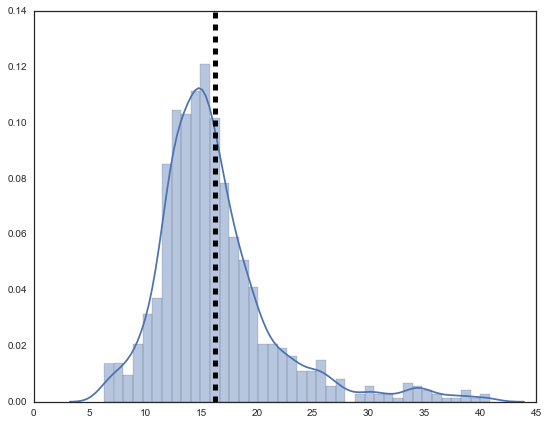

In [9]:
fig = plt.figure(figsize=(9,7))
ax = fig.gca()

ax = sns.distplot(delay, bins=40, ax=ax)
ax.axvline(mean_delay, lw=5, ls='dashed', color='black')

plt.show()

Why are we examing our mean delay? With MCMC, we want to inform the posterior for *m* our mean. 

In [10]:
number_obs = len(delay)

In [11]:
print number_obs

841


Let's go ahead and take a subset out our data to examine it as well: 

In [12]:
delay_subset = np.random.choice(delay, replace=False, size=50)

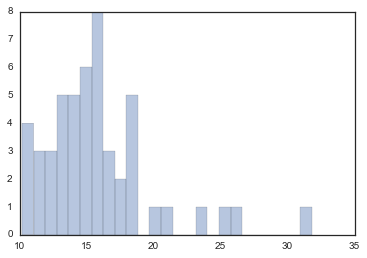

In [14]:
sns.distplot(delay_subset, bins=25, norm_hist=False, kde=False)

Here, we're defining our prior. Recall that for every paramter we want to infer, in this case *m*, we must have a prior. Since we have a normal distribution with a known standard deviation, the prior for *m* is a **conjugate** and therefore also normal. 

In [16]:
weak_prior = stats.norm(20, 10)
strong_prior = stats.norm(20, 1)

Here, we're simply graphing our strong prior and weak prior

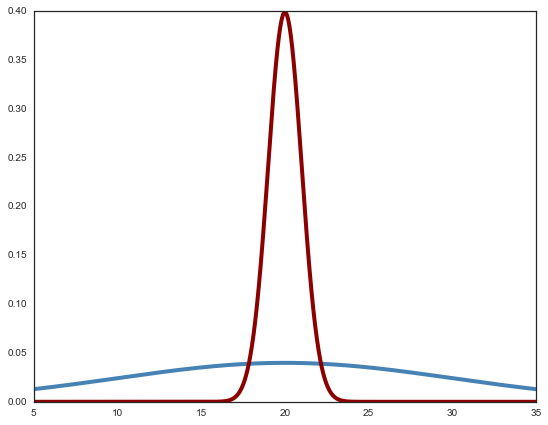

In [17]:
fig = plt.figure(figsize=(9,7))
ax = fig.gca()

minute_range = np.linspace(5, 35, 30*200)

weak_pdf = weak_prior.pdf(minute_range)
strong_pdf = strong_prior.pdf(minute_range)

ax.plot(minute_range, weak_pdf, color='steelblue', lw=4)
ax.plot(minute_range, strong_pdf, color='darkred', lw=4)

plt.show()

Below, we define out parameters for our MCMC. We're defining the mean and standard deviation of our original prior, and setting it's distribution as normal given the logic we fleshed our above. You'll see some new terminology here, however, and that is the **initial statistic** and **proposal**.

The ```initial_statistic``` is simply our starting position for the **random walk** like process the the Monte Carlo algorithm utilizes. The proposal is the process by which the Markov Chain models all potential states - you *propose* the alogorithm to move from one state position to the next.



In [27]:
original_prior_mean = 20 
original_prior_std = 7

prior_distribution = stats.norm
proposal_distribution = stats.norm

proposal_avg_step = 1
initial_statistic = 20 
iterations = 500

Now, we're defining all of the aspects of our MCMC. Let's run through them: 

- The **likelihood**: We measure fit by deriving the probability of the data, given the likelihood with the proposed parameter values. Here, the statistic is just going to be the mean delay, the statistic we are measuring *P* is our prior belief about what the distribution of mean delays are data is our observed flight delays. The log likehood is typically used in MCMC, so I've included both standard likelihood and log-liklihood. 

- ```prior_logpdf```: Gets the log pdf for single means, given a prior statistic (mean) and standard deviation.

- The calculation of the **proposal**, which we just discussed above.

With these functions, we have a climing algorithm that proposes random jumps and will accept those jumps with the value of *m* has a higher liklihood than the previous value of *m*. Our algorithm will continue to repeat these steps. We introduce the metropolis sampler to create random draws from a “jump” distribution centered on the current parameter value defined by an acceptance criteria. This is essentially the iterative method that our algorithm uses. 

Lastly, we put the whole process together in a wrapped up MCMC that utilizes everything that we've discussed above.

In [25]:
def log_likelihood(data, statistic, prior_distribution, prior_std):    
    prior = prior_distribution(statistic, prior_std)
    loglike = prior.logpdf(data)
    return np.sum(loglike)

def likelihood(data, statistic, prior_distribution, prior_std):
    prior = prior_distribution(statistic, prior_std)
    like = prior.pdf(data)
    return like

def prior_logpdf(statistic, prior_distribution, prior_statistic, prior_std):
    prior = prior_distribution(prior_statistic, prior_std)
    statistic_logpdf = prior.logpdf(statistic)
    return statistic_logpdf

def proposal(statistic, proposal_distribution, step_size):
    dist = proposal_distribution(statistic, step_size)
    new_proposed_statistic = dist.rvs()
    return new_proposed_statistic

def metropolis_sampler(data, statistic, prior_distribution, prior_statistic, prior_std,
                       proposal_distribution, proposal_avg_step):
    
    current_loglike = log_likelihood(data, statistic, prior_distribution, prior_std)
    current_prior_loglike = prior_logpdf(statistic, prior_distribution, prior_statistic, prior_std)
    
    proposed_shift = proposal(statistic, proposal_distribution, proposal_avg_step)
    proposed_loglike = log_likelihood(data, proposed_shift, prior_distribution, prior_std)
    proposed_prior_loglike = prior_logpdf(proposed_shift, prior_distribution, prior_statistic, prior_std)
    
    current_posterior_numerator_loglike = current_loglike + current_prior_loglike
    proposed_posterior_numerator_loglike = proposed_loglike + proposed_prior_loglike
    
    acceptance_criterion = np.exp(proposed_posterior_numerator_loglike - current_posterior_numerator_loglike)
    
    accept = acceptance_criterion > np.random.rand()
    
    if accept:
        return proposed_shift
    else:
        return statistic
    
def markov_chain_monte_carlo(data, initial_statistic,
                             prior_distribution, prior_statistic, prior_std,
                             proposal_distribution, proposal_avg_step,
                             iterations=1000):
    
    statistic_posterior = [initial_statistic]
    
    current_statistic = initial_statistic
    
    for i in range(iterations):
        
        current_statistic = metropolis_sampler(data, current_statistic, prior_distribution, 
                                               prior_statistic, prior_std,
                                               proposal_distribution, proposal_avg_step)
        
        statistic_posterior.append(current_statistic)
        
    return statistic_posterior
    

In [22]:
delay_loglikes = log_likelihood(delay_subset, 20, stats.norm, 10)
delay_likes = likelihood(delay_subset, 20, stats.norm, 10)

weak_likelihood = np.prod(np.exp(delay_loglikes))
print weak_likelihood

1.66714414815e-74


With that, we want want to calculate our posterior *m* by wrapping everying up into our MCMC. 

In [28]:
posterior_mean_delay = markov_chain_monte_carlo(delay, initial_statistic, prior_distribution, original_prior_mean, original_prior_std, proposal_distribution, proposal_avg_step, iterations=iterations)

Lastly, we can visualize our results:

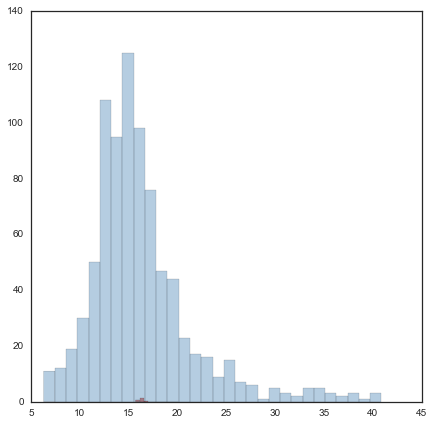

In [31]:
plt.figure(figsize=(7, 7))

plt.hist(delay, color='steelblue', alpha=0.4, bins=30, normed=False)
plt.hist(posterior_mean_delay, color='darkred', alpha=0.4, bins=10, normed=True)

plt.show()

In [32]:
print np.mean(posterior_mean_delay), np.mean(delay_subset)

16.2822488292 15.7786


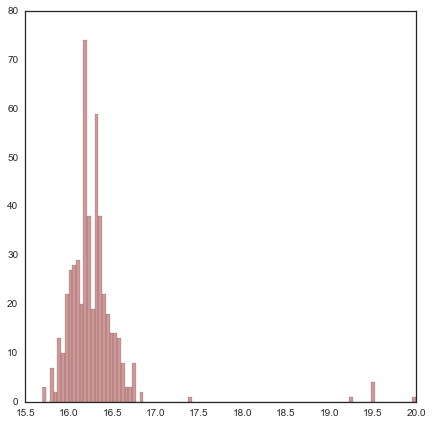

In [33]:
plt.figure(figsize=(7, 7))

plt.hist(posterior_mean_delay, color='darkred', alpha=0.4, bins=100, normed=False)

plt.show()

## Wrapping it all up

Now that we've learned about MCMC - how exactly is it useful and when will we ever be utilizing it in a practical sense? MCMC methods are some of the **most frequently used algorithms in computer science**. Let's look at some examples: 

- MCMC's are frequently used in Cryptology to decipher coded messages. If we look at the cypher code as the posterior, we can translate the cypher into human alphabet using an MCMC. 
- Hotels, airlines, and the like use MCMC's to analyze the rewards programs by deriving information from the simulated distribution that MCMC creates. 
- Governments utilizing MCMC to model the deterioration of public infrastructure (Maybe Metro should have used an MCMC!) 